# Semantic Segmentation <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/dinov2/blob/main/notebooks/semantic_segmentation.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys

INSTALL = False # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    REPO_PATH = "../dinvo2" # Specify a local path to the repository (or use installed package instead)
    sys.path.append(REPO_PATH)

## Utilities

In [2]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F
from mmseg.apis import init_segmentor, inference_segmentor

sys.path.append('../dinov2-root')

import dinov2.eval.segmentation.models


class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_segmenter(cfg, backbone_model):
    model = init_segmentor(cfg)
    model.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
    )
    if hasattr(backbone_model, "patch_size"):
        model.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))
    model.init_weights()
    return model

## Load pretrained backbone

In [3]:
# torch.cuda.device_count()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
# print device name
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce GTX 1650


In [4]:
BACKBONE_SIZE = "small" # in ("small", "base", "large" or "giant")

backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}

backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

Using cache found in /home/sid/.cache/torch/hub/facebookresearch_dinov2_main
/home/sid/IITB/KCDH/code/../dinov2-root/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/sid/IITB/KCDH/code/../dinov2-root/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/sid/IITB/KCDH/code/../dinov2-root/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


## Load pretrained segmentation head

In [4]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_SCALE_COUNT = 5 # more scales: slower but better results, in (1,2,3,4,5)
HEAD_DATASET = "voc2012" # in ("ade20k", "voc2012")
HEAD_TYPE = "ms" # in ("ms, "linear")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")
if HEAD_TYPE == "ms":
    cfg.data.test.pipeline[1]["img_ratios"] = cfg.data.test.pipeline[1]["img_ratios"][:HEAD_SCALE_COUNT]
    print("scales:", cfg.data.test.pipeline[1]["img_ratios"])

model = create_segmenter(cfg, backbone_model=backbone_model)
load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.cuda()
model.eval()

/home/sid/IITB/KCDH/env1/lib/python3.10/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
2024-05-09 18:15:50,995 - mmcv - INFO - initialize BNHead with init_cfg {'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
2024-05-09 18:15:51,013 - mmcv - INFO - 
decode_head.conv_seg.weight - torch.Size([21, 1536, 1, 1]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2024-05-09 18:15:51,015 - mmcv - INFO - 
decode_head.conv_seg.bias - torch.Size([21]): 
NormalInit: mean=0, std=0.01, bias=0 
 
2024-05-09 18:15:51,015 - mmcv - INFO - 
decode_head.bn.weight - torch.Size([1536]): 
The value is the same before and after calling `init_weights` of EncoderDecoder  
 
2024-05-09 18:15:51,017 - mmcv - INFO - 
decode_head.bn.bias - torch.Size([1536]): 

scales: [1.0, 1.32, 1.73, 2.28, 3.0]
load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_voc2012_ms_head.pth


EncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): BNHead(
    input_transform=resize_concat, ignore_index=255, align_corners=False
    (loss_decode): CrossEntropyLoss(avg_non_ignore=False)
    (conv_seg): Conv2d(1536, 21, kernel_size=(1, 1), stride=(1, 1))
    (bn): SyncBatchNorm(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  init_cfg={'type': 'Normal', 'std': 0.01, 'override': {'name': 'conv_seg'}}
)

## Load sample image

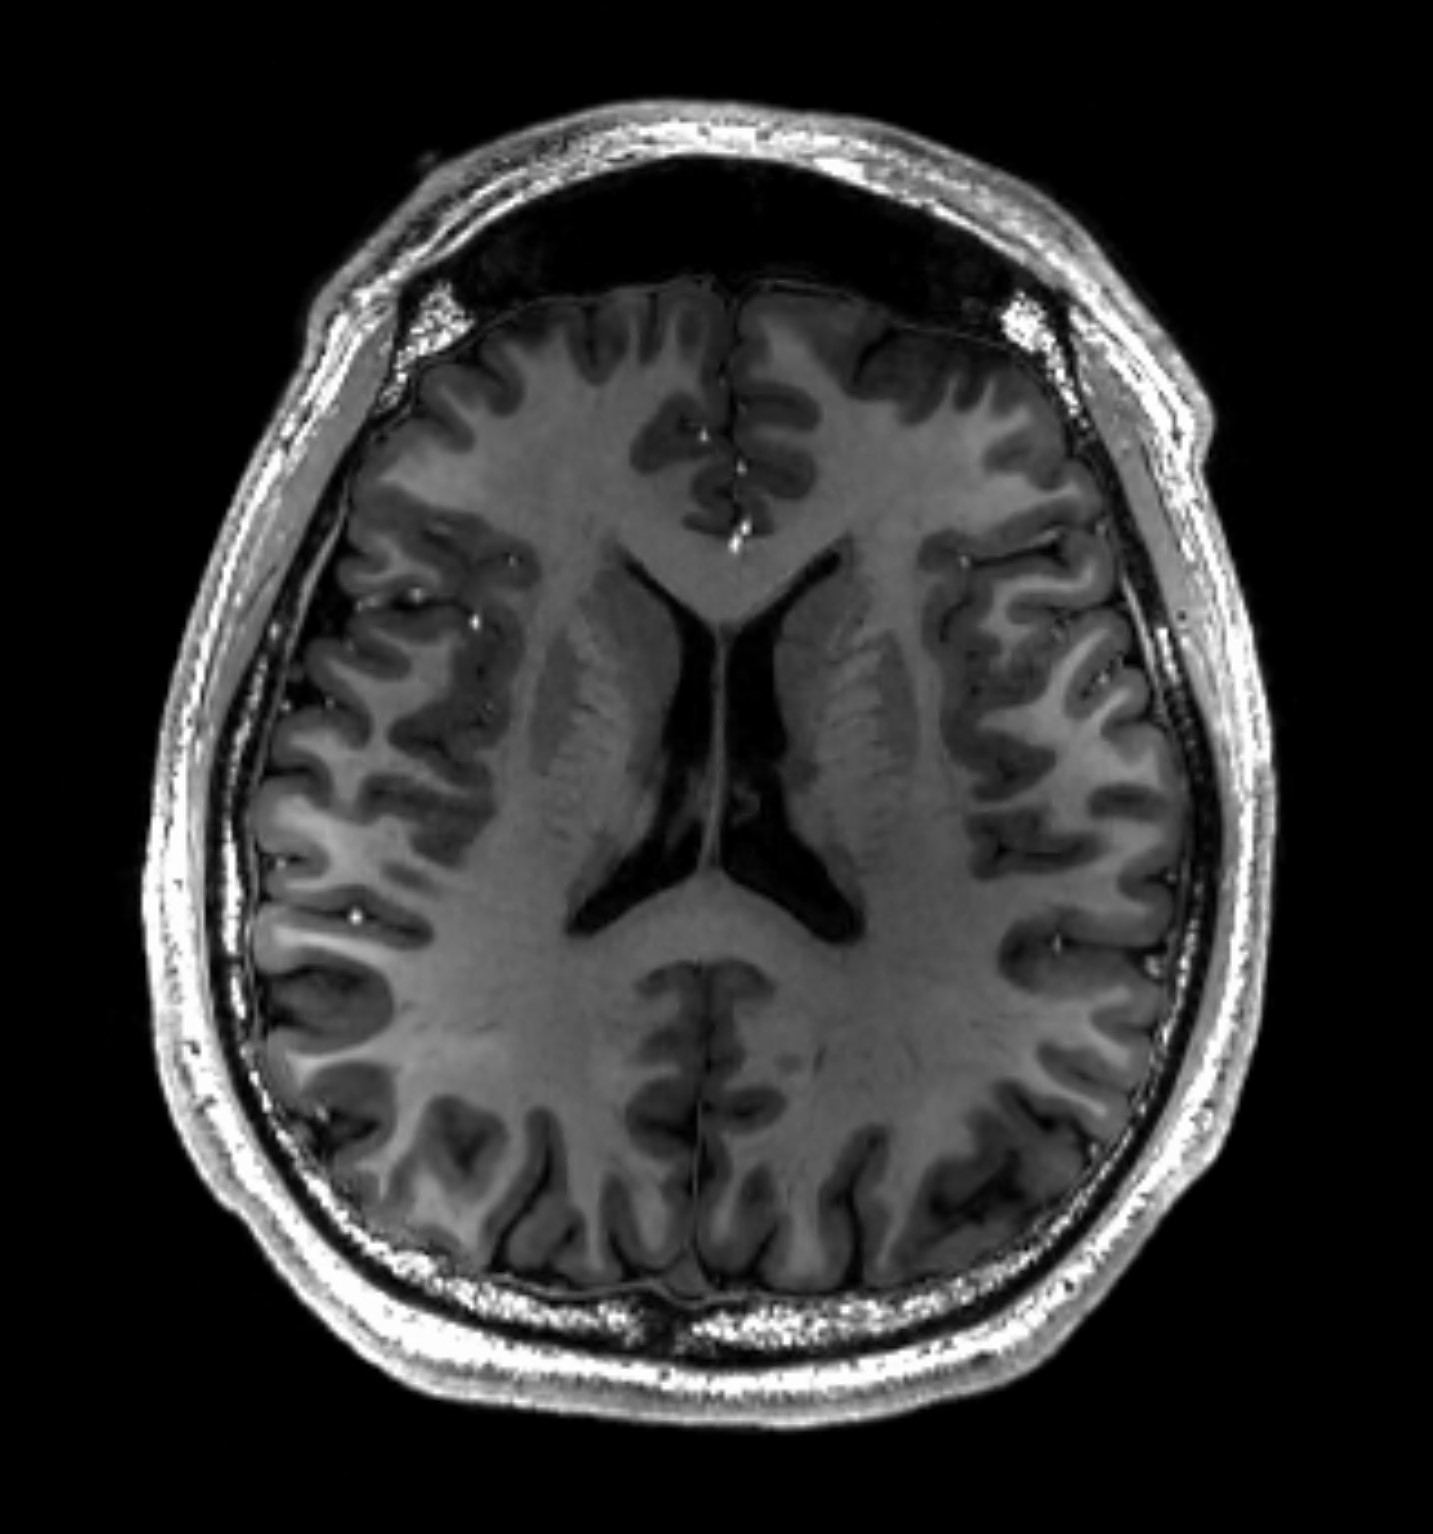

In [5]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


# EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
EXAMPLE_IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/b/b2/MRI_of_Human_Brain.jpg"


image = load_image_from_url(EXAMPLE_IMAGE_URL)
display(image)

## Semantic segmentation on sample image

In [6]:
import numpy as np

import dinov2.eval.segmentation.utils.colormaps as colormaps


DATASET_COLORMAPS = {
    "ade20k": colormaps.ADE20K_COLORMAP,
    "voc2012": colormaps.VOC2012_COLORMAP,
}


def render_segmentation(segmentation_logits, dataset):
    colormap = DATASET_COLORMAPS[dataset]
    colormap_array = np.array(colormap, dtype=np.uint8)
    segmentation_values = colormap_array[segmentation_logits + 1]
    return Image.fromarray(segmentation_values)


array = np.array(image)[:, :, ::-1] # BGR
segmentation_logits = inference_segmentor(model, array)[0]
segmented_image = render_segmentation(segmentation_logits, HEAD_DATASET)
display(segmented_image)

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
